In [ ]:
# === prerequisites ===
# pip install imbalanced-learn xgboost optuna openml

import pandas as pd
import numpy as np
import optuna
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd

dataset = fetch_ucirepo(id=697)
X = dataset.data.features
y = dataset.data.targets
print(f"Features shape: {X.shape}, Target shape: {y.shape}")

print(X.columns.tolist())


Features shape: (4424, 36), Target shape: (4424, 1)
['Marital Status', 'Application mode', 'Application order', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Previous qualification (grade)', 'Nacionality', "Mother's qualification", "Father's qualification", "Mother's occupation", "Father's occupation", 'Admission grade', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rat

In [ ]:
# Simple preprocessing: encode targets and split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_enc = le.fit_transform(y)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# After your split...
total = X.shape[0]
train_pct = X_train.shape[0] / total * 100
test_pct  = X_test.shape[0]  / total * 100

print(f"Train: {X_train.shape} ({train_pct:.1f}%), Test: {X_test.shape} ({test_pct:.1f}%)")

Train: (3539, 36), Test: (885, 36)
Train: (3539, 36) (80.0%), Test: (885, 36) (20.0%)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


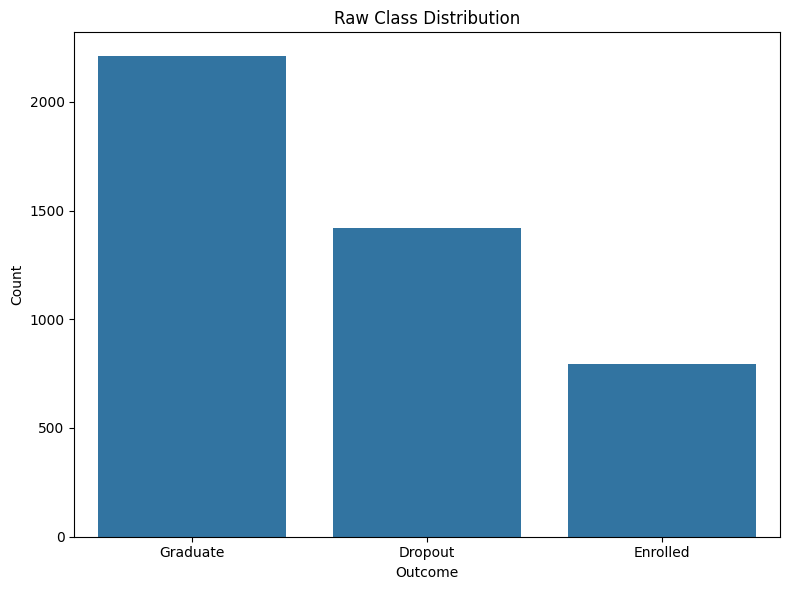

Current counts per class:
outcome
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Additional samples needed to balance all classes to 2209 each:
outcome
Graduate       0
Dropout      788
Enrolled    1415
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1) Build a DataFrame for the raw labels (before encoding)
df_labels = pd.DataFrame({'outcome': le.inverse_transform(y_enc)})

# 2) Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(
    x='outcome',
    data=df_labels,
    order=df_labels['outcome'].value_counts().index
)
plt.title('Raw Class Distribution')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 3) Compute counts per class
counts = df_labels['outcome'].value_counts()
print("Current counts per class:")
print(counts)

# 4) How many to add to match the largest class
max_count = counts.max()
needed = max_count - counts
print("\nAdditional samples needed to balance all classes to", max_count, "each:")
print(needed)


In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# ─── A) After you’ve done your stratified split ───
#    (you already have X_train, X_test as DataFrames,
#     y_train, y_test as numpy arrays or lists of strings)

import numpy as np

# After your train_test_split → you have y_train, y_test as numpy arrays

# 1) Inspect the unique values
unique_vals = np.unique(y_train)
print("Unique y_train values:", unique_vals)

# 2) If they're already in {0,1,2}, just cast to int and move on;
#    otherwise wrap+map as before.
if set(unique_vals).issubset({0, 1, 2}):
    y_train_enc = y_train.astype(int)
    y_test_enc  = y_test.astype(int)
    print("Labels already numeric, skipping map.")
else:
    # your old mapping logic
    import pandas as pd
    label_map = {'dropout': 0, 'enrolled': 1, 'graduate': 2}
    s_train = pd.Series(y_train, name='outcome')
    s_test  = pd.Series(y_test,  name='outcome')
    y_train_enc = s_train.map(label_map)
    y_test_enc  = s_test.map(label_map)

    # catch any unmapped labels
    unmapped_train = s_train[y_train_enc.isna()].unique()
    unmapped_test  = s_test [y_test_enc.isna()].unique()
    if len(unmapped_train):
        raise ValueError(f"Train labels not in map: {unmapped_train}")
    if len(unmapped_test):
        raise ValueError(f"Test  labels not in map: {unmapped_test}")

    y_train_enc = y_train_enc.astype(int).to_numpy()
    y_test_enc  = y_test_enc.astype(int).to_numpy()

# 3) Quick sanity check
from collections import Counter
print("Encoded train counts:", Counter(y_train_enc))
print("Encoded test  counts:",  Counter(y_test_enc))


# ─── B) One-hot encode your FEATURES ───
X_train_enc = pd.get_dummies(X_train, drop_first=True)
X_test_enc  = pd.get_dummies(X_test,  drop_first=True) \
                    .reindex(columns=X_train_enc.columns, fill_value=0)

# ─── C) Show counts before SMOTE ───
print("\nBefore SMOTE:", Counter(y_train_enc))

# ─── D) Apply plain SMOTE on the TRAINING data only ───
sm   = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_enc, y_train_enc)
print("After SMOTE: ", Counter(y_res))

# ─── E) (Optional) Print your full/train/res counts side-by-side ───
print("\nFull dataset counts:")
print(df_labels['outcome'].value_counts().sort_index())

print("\nTraining split counts (80% stratified):")
train_counts = pd.Series(y_train_enc, name='outcome').value_counts().sort_index()
print(train_counts)

print("\nAfter SMOTE (all up-sampled to majority class):")
res_counts = pd.Series(y_res, name='outcome').value_counts().sort_index()
print(res_counts)

# ─── F) Now y_res is a clean integer array 0/1/2 and X_res is numeric,
#      you can plug X_res, y_res into your Optuna tune_* functions, CV, etc.

Unique y_train values: [0 1 2]
Labels already numeric, skipping map.
Encoded train counts: Counter({np.int64(2): 1767, np.int64(0): 1137, np.int64(1): 635})
Encoded test  counts: Counter({np.int64(2): 442, np.int64(0): 284, np.int64(1): 159})

Before SMOTE: Counter({np.int64(2): 1767, np.int64(0): 1137, np.int64(1): 635})
After SMOTE:  Counter({np.int64(2): 1767, np.int64(0): 1767, np.int64(1): 1767})

Full dataset counts:
outcome
Dropout     1421
Enrolled     794
Graduate    2209
Name: count, dtype: int64

Training split counts (80% stratified):
outcome
0    1137
1     635
2    1767
Name: count, dtype: int64

After SMOTE (all up-sampled to majority class):
outcome
0    1767
1    1767
2    1767
Name: count, dtype: int64


In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
# ─── 3) Set up a stratified CV splitter ───
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ─── 4) Define tuning functions for Optuna ───
def tune_xgb(trial):
    params = {
        'n_estimators':       trial.suggest_int('n_estimators', 50, 300),
        'max_depth':          trial.suggest_int('max_depth', 3, 10),
        'learning_rate':      trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'subsample':          trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree':   trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma':              trial.suggest_float('gamma', 0, 5),
        'verbosity':          0,
        'objective':          'multi:softprob',
        'num_class':          3,
        'eval_metric':        'mlogloss',
        'random_state':       42
    }
    model = XGBClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

def tune_lgb(trial):
    params = {
        'n_estimators':     trial.suggest_int('n_estimators', 50, 300),
        'max_depth':        trial.suggest_int('max_depth', 3, 10),
        'learning_rate':    trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves':       trial.suggest_int('num_leaves', 20, 100),
        'subsample':        trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'objective':        'multiclass',
        'num_class':        3,
        'eval_metric':      'multi_logloss',
        'verbosity':        -1,
        'random_state':     42
    }
    model = LGBMClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

def tune_cat(trial):
    params = {
        'iterations':    trial.suggest_int('iterations', 50, 300),
        'depth':         trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'l2_leaf_reg':   trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'loss_function': 'MultiClass',
        'verbose':       False,
        'random_seed':   42
    }
    model = CatBoostClassifier(**params)
    return cross_val_score(model, X_res, y_res, cv=cv, scoring='f1_macro', n_jobs=-1).mean()

# ─── 5) Run Optuna studies ───
studies = {}
for name, fn in [('XGB', tune_xgb), ('LGB', tune_lgb), ('CAT', tune_cat)]:
    study = optuna.create_study(direction='maximize')
    study.optimize(fn, n_trials=20)
    studies[name] = study
    print(f"Best {name} F1_macro: {study.best_value:.4f}")


[I 2025-04-28 03:37:12,850] A new study created in memory with name: no-name-e29a1101-1438-42e5-870f-7b44578a41dd
[I 2025-04-28 03:37:24,340] Trial 0 finished with value: 0.795970119894106 and parameters: {'n_estimators': 113, 'max_depth': 10, 'learning_rate': 0.003906245943407467, 'subsample': 0.8751559857589648, 'colsample_bytree': 0.6118609822192139, 'gamma': 2.241368452374459}. Best is trial 0 with value: 0.795970119894106.
[I 2025-04-28 03:37:40,089] Trial 1 finished with value: 0.8067634626283253 and parameters: {'n_estimators': 211, 'max_depth': 8, 'learning_rate': 0.01095925474179685, 'subsample': 0.6184022235447326, 'colsample_bytree': 0.6907458374442448, 'gamma': 1.3928345272532794}. Best is trial 1 with value: 0.8067634626283253.
[I 2025-04-28 03:37:49,861] Trial 2 finished with value: 0.7826900340480656 and parameters: {'n_estimators': 178, 'max_depth': 10, 'learning_rate': 0.0016499516300419585, 'subsample': 0.8830301512989474, 'colsample_bytree': 0.6030381168320939, 'gamm

Best XGB F1_macro: 0.8527


[I 2025-04-28 03:39:46,742] Trial 0 finished with value: 0.7949478892637757 and parameters: {'n_estimators': 253, 'max_depth': 8, 'learning_rate': 0.004806293402473033, 'num_leaves': 41, 'subsample': 0.7676379193259887, 'colsample_bytree': 0.8037663805871618}. Best is trial 0 with value: 0.7949478892637757.
[I 2025-04-28 03:39:49,013] Trial 1 finished with value: 0.7713751600801197 and parameters: {'n_estimators': 169, 'max_depth': 4, 'learning_rate': 0.011334677702450098, 'num_leaves': 46, 'subsample': 0.6505731631693975, 'colsample_bytree': 0.6609674105654019}. Best is trial 0 with value: 0.7949478892637757.
[I 2025-04-28 03:39:56,846] Trial 2 finished with value: 0.8249192784192634 and parameters: {'n_estimators': 280, 'max_depth': 8, 'learning_rate': 0.01371189517624848, 'num_leaves': 40, 'subsample': 0.7762506217927803, 'colsample_bytree': 0.7783078719316134}. Best is trial 2 with value: 0.8249192784192634.
[I 2025-04-28 03:40:03,707] Trial 3 finished with value: 0.842446262072567

Best LGB F1_macro: 0.8583


[I 2025-04-28 03:42:29,322] Trial 0 finished with value: 0.7772399503404882 and parameters: {'iterations': 176, 'depth': 8, 'learning_rate': 0.014988498405325864, 'l2_leaf_reg': 0.0011898529715995388}. Best is trial 0 with value: 0.7772399503404882.
[I 2025-04-28 03:42:46,253] Trial 1 finished with value: 0.7133798828580211 and parameters: {'iterations': 91, 'depth': 8, 'learning_rate': 0.0010509193779588617, 'l2_leaf_reg': 0.0037857981509387202}. Best is trial 0 with value: 0.7772399503404882.
[I 2025-04-28 03:42:57,101] Trial 2 finished with value: 0.7260746805482288 and parameters: {'iterations': 295, 'depth': 4, 'learning_rate': 0.006104456315834449, 'l2_leaf_reg': 0.024469909171220224}. Best is trial 0 with value: 0.7772399503404882.
[I 2025-04-28 03:43:29,621] Trial 3 finished with value: 0.7371173002703557 and parameters: {'iterations': 175, 'depth': 8, 'learning_rate': 0.0046863353087929355, 'l2_leaf_reg': 0.6107651885898534}. Best is trial 0 with value: 0.7772399503404882.
[I 

Best CAT F1_macro: 0.8481


In [ ]:
# ─── 6) Instantiate tuned models ───
best_xgb = XGBClassifier(**studies['XGB'].best_params,
                         verbosity=0,
                         objective='multi:softprob',
                         num_class=3,
                         eval_metric='mlogloss',
                         random_state=42)

best_lgb = LGBMClassifier(**studies['LGB'].best_params,
                          objective='multiclass',
                          num_class=3,
                          eval_metric='multi_logloss',
                          verbosity=-1,
                          random_state=42)

best_cat = CatBoostClassifier(**studies['CAT'].best_params,
                              loss_function='MultiClass',
                              verbose=False,
                              random_seed=42)

# ─── 7) Fit & evaluate on the TEST set ───
for name, model in [('XGBoost', best_xgb),
                    ('LightGBM', best_lgb),
                    ('CatBoost', best_cat)]:
    model.fit(X_res, y_res)
    y_pred = model.predict(X_test_enc)
    print(f"\n--- {name} on Test Set ---")
    print("Accuracy:", accuracy_score(y_test_enc, y_pred))
    print(classification_report(y_test_enc, y_pred,
                                target_names=label_map.keys()))


--- XGBoost on Test Set ---
Accuracy: 0.7570621468926554
              precision    recall  f1-score   support

     dropout       0.80      0.73      0.76       284
    enrolled       0.50      0.51      0.51       159
    graduate       0.82      0.87      0.84       442

    accuracy                           0.76       885
   macro avg       0.71      0.70      0.70       885
weighted avg       0.76      0.76      0.76       885


--- LightGBM on Test Set ---
Accuracy: 0.7638418079096045
              precision    recall  f1-score   support

     dropout       0.81      0.74      0.77       284
    enrolled       0.51      0.50      0.51       159
    graduate       0.82      0.87      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.71      0.71       885
weighted avg       0.76      0.76      0.76       885


--- CatBoost on Test Set ---
Accuracy: 0.7615819209039548
              precision    recall  f1-score   support

     dr